In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fracture-multi-region-x-ray-data/README.dataset.txt
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/19-rotated3-rotated2.jpg
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004347.jpg
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/26-rotated2-rotated2-rotated2.jpg
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/1-rotated3-rotated2.jpg
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/0013.png
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/12-ro

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Flatten, ELU, Dense, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Nadam

In [3]:
from pathlib import Path
import imghdr

# Define the data directories
train_dir = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train"
val_dir = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val"
test_dir = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test"

# Specific file types to be checked
image_extensions = [".png", ".jpg"]

# Allowed image types for TensorFlow
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

def check_images(directory, image_extensions, img_type_accepted_by_tf):
    for filepath in Path(directory).rglob("*"):
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

# Check images in train, validation, and test directories
print("Checking train directory...")
check_images(train_dir, image_extensions, img_type_accepted_by_tf)

print("\nChecking validation directory...")
check_images(val_dir, image_extensions, img_type_accepted_by_tf)

print("\nChecking test directory...")
check_images(test_dir, image_extensions, img_type_accepted_by_tf)

Checking train directory...
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0000505.jpg is not an image
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/leg-xray-showing-closed-spiral-260nw-1586443063.jpg is not an image
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/IMG0002511.jpg is not an image
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/IMG0002447.jpg is not an image
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured/IMG0002445.jpg is not an image
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Bina

Found 9246 files belonging to 2 classes.
Found 829 files belonging to 2 classes.
Found 506 files belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


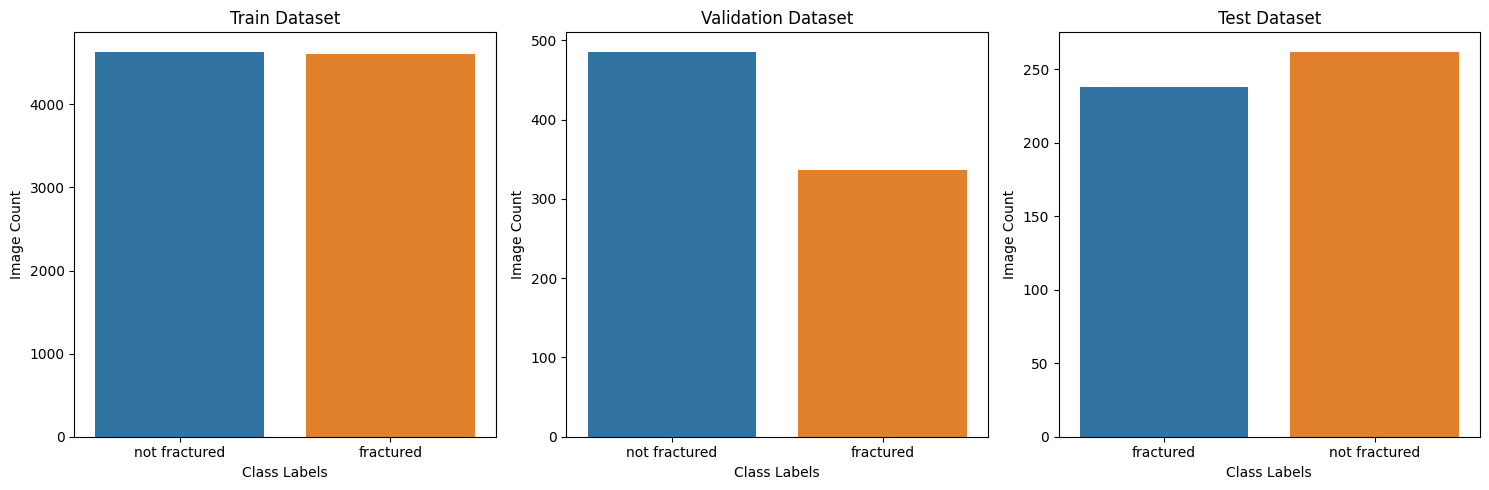

Train label counts:
not fractured: 4634
fractured: 4606

Validation label counts:
not fractured: 486
fractured: 337

Test label counts:
fractured: 238
not fractured: 262


In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Function to check if an image is valid
def is_valid_image(image_path):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        return True
    except:
        return False

# Function to load dataset and get label counts
def load_dataset_and_get_label_counts(directory_path, image_size=(64, 64), batch_size=32):
    dataset = keras.utils.image_dataset_from_directory(
        directory_path,
        image_size=image_size,
        batch_size=batch_size
    )
    valid_file_paths = []
    for file_path in dataset.file_paths:
        if is_valid_image(file_path):
            valid_file_paths.append(file_path)
    
    # Recreate the dataset with only valid images
    dataset = tf.data.Dataset.from_tensor_slices(valid_file_paths)
    dataset = dataset.map(lambda x: (tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(x), channels=3), image_size), tf.strings.split(x, '/')[-2]))
    labels = []
    for image, label in dataset:
        labels.append(label.numpy())
    
    label_counts = Counter(labels)
    return dataset, label_counts

# Loading train dataset
train_dataset, train_label_counts = load_dataset_and_get_label_counts(
    "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train"
)

# Loading validation dataset
val_dataset, val_label_counts = load_dataset_and_get_label_counts(
    "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val"
)

# Loading test dataset
test_dataset, test_label_counts = load_dataset_and_get_label_counts(
    "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test"
)

# Function to format label counts
def format_label_counts(label_counts):
    formatted_counts = {label.decode('utf-8'): count for label, count in label_counts.items()}
    return formatted_counts

# Formatting the label counts
formatted_train_counts = format_label_counts(train_label_counts)
formatted_val_counts = format_label_counts(val_label_counts)
formatted_test_counts = format_label_counts(test_label_counts)

# Plotting the counts
plt.figure(figsize=(15, 5))

# Train dataset
plt.subplot(1, 3, 1)
sns.barplot(x=list(formatted_train_counts.keys()), y=list(formatted_train_counts.values()))
plt.title('Train Dataset')
plt.xlabel('Class Labels')
plt.ylabel('Image Count')

# Validation dataset
plt.subplot(1, 3, 2)
sns.barplot(x=list(formatted_val_counts.keys()), y=list(formatted_val_counts.values()))
plt.title('Validation Dataset')
plt.xlabel('Class Labels')
plt.ylabel('Image Count')

# Test dataset
plt.subplot(1, 3, 3)
sns.barplot(x=list(formatted_test_counts.keys()), y=list(formatted_test_counts.values()))
plt.title('Test Dataset')
plt.xlabel('Class Labels')
plt.ylabel('Image Count')

plt.tight_layout()
plt.show()

# Printing counts
print("Train label counts:")
for label, count in formatted_train_counts.items():
    print(f"{label}: {count}")

print("\nValidation label counts:")
for label, count in formatted_val_counts.items():
    print(f"{label}: {count}")

print("\nTest label counts:")
for label, count in formatted_test_counts.items():
    print(f"{label}: {count}")

In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from tqdm import tqdm

# Function to check if an image is valid
def is_valid_image(image_path):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        return True
    except:
        return False

# Function to collect valid image file paths and their labels
def collect_valid_image_paths_and_labels(directory_path):
    valid_image_paths_and_labels = []
    for root, dirs, files in os.walk(directory_path):
        for file in tqdm(files):
            if file.lower().endswith(('.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                if is_valid_image(file_path):
                    label = os.path.basename(root)
                    valid_image_paths_and_labels.append((file_path, label))
    return valid_image_paths_and_labels

# Function to create a dataset from valid image paths and labels
def create_dataset_from_valid_paths_and_labels(image_paths_and_labels, image_size=(224, 224), batch_size=32):
    # Create dataset from image paths and labels
    image_paths, labels = zip(*image_paths_and_labels)
    dataset = tf.data.Dataset.from_tensor_slices((list(image_paths), list(labels)))
    
    # Load and preprocess images
    def load_and_preprocess_image(image_path, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, image_size)
        image = image / 255.0  # Normalize
        return image, label
    
    dataset = dataset.map(load_and_preprocess_image)
    
    # Create a lookup table for label encoding
    label_list = list(set(label for _, label in image_paths_and_labels))
    label_lookup = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(label_list, tf.range(len(label_list))),
        default_value=-1
    )
    
    # Encode labels using the lookup table
    def encode_labels(image, label):
        label_index = label_lookup.lookup(label)
        return image, label_index
    
    dataset = dataset.map(encode_labels)
    
    # Batch the dataset
    dataset = dataset.batch(batch_size)
    
    return dataset, label_list

# Function to get images and labels from a dataset
def get_images_and_labels(dataset):
    images_list = []
    labels_list = []
    for images, labels in dataset:
        images_list.append(images.numpy())
        labels_list.append(labels.numpy())
    return np.concatenate(images_list), np.concatenate(labels_list)

# Paths to the directories
train_dir = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train"
val_dir = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val"
test_dir = "/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test"

# Collecting valid image paths and labels
train_image_paths_and_labels = collect_valid_image_paths_and_labels(train_dir)
val_image_paths_and_labels = collect_valid_image_paths_and_labels(val_dir)
test_image_paths_and_labels = collect_valid_image_paths_and_labels(test_dir)

# Creating datasets
train_dataset, label_list = create_dataset_from_valid_paths_and_labels(train_image_paths_and_labels)
val_dataset, _ = create_dataset_from_valid_paths_and_labels(val_image_paths_and_labels)
test_dataset, _ = create_dataset_from_valid_paths_and_labels(test_image_paths_and_labels)

# Getting images and labels
train_images, train_labels = get_images_and_labels(train_dataset)
val_images, val_labels = get_images_and_labels(val_dataset)
test_images, test_labels = get_images_and_labels(test_dataset)

# Printing the shapes and labels
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)
print("Label list:", label_list)

0it [00:00, ?it/s]
100%|██████████| 4606/4606 [00:08<00:00, 525.04it/s]
0it [00:00, ?it/s]
100%|██████████| 337/337 [00:01<00:00, 300.80it/s]
0it [00:00, ?it/s]
100%|██████████| 238/238 [00:00<00:00, 843.19it/s]


Train images shape: (9165, 224, 224, 3)
Train labels shape: (9165,)
Validation images shape: (764, 224, 224, 3)
Validation labels shape: (764,)
Test images shape: (443, 224, 224, 3)
Test labels shape: (443,)
Label list: ['fractured', 'not fractured']


In [6]:
import gc # calling garbage collector to reduce memory allocation 

del train_dataset
del val_dataset
del test_dataset

gc.collect()

10554

In [7]:
from keras import mixed_precision # changing precision policies
mixed_precision.set_global_policy('mixed_float16')

In [8]:
tf.config.optimizer.set_jit(True) # setting optimizer to reduce model computation by optimizing graph-computations

In [9]:
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau

# Loading model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block4_pool').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.summary() # printing summary of model

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast (Cast)                          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,161,601 (31.13 MB)

 Trainable params: 526,337 (2.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=20, batch_size=250,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5448 - loss: 0.9626   
Epoch 1: val_accuracy improved from -inf to 0.78272, saving model to model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.5461 - loss: 0.9575 - val_accuracy: 0.7827 - val_loss: 0.5431 - learning_rate: 0.0010
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7415 - loss: 0.5454
Epoch 2: val_accuracy did not improve from 0.78272
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 451ms/step - accuracy: 0.7420 - loss: 0.5448 - val_accuracy: 0.7696 - val_loss: 0.5154 - learning_rate: 0.0010
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8101 - loss: 0.4583
Epoch 3: val_accuracy improved from 0.78272 to 0.79712, saving model to model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.8102 - loss: 0.4580 - val_accuracy: 0.7971 - val_loss: 0.4336 - learning_rate: 0.0010
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8293 - loss: 0.4088
Epoch 4: val_acc

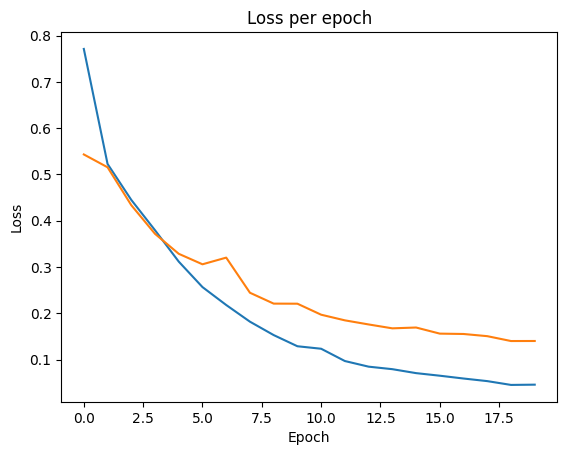

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

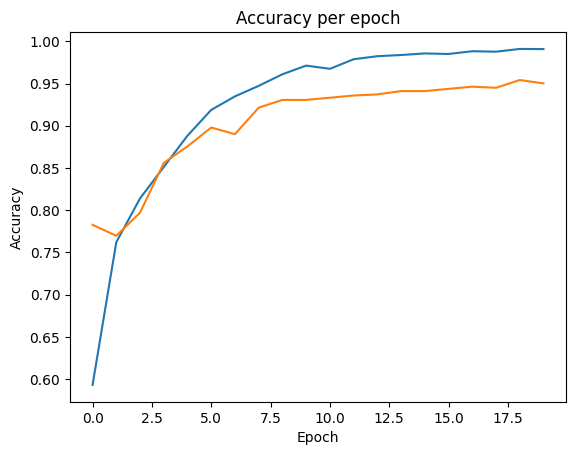

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

In [13]:
import keras
from keras.models import load_model

# Load the model from the file
model1 = load_model("model.keras")

# Evaluate the model on the test data
results = model1.evaluate(test_images, test_labels)

# Print the results
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 564ms/step - accuracy: 0.9435 - loss: 0.1903
Test Loss: 0.12956927716732025
Test Accuracy: 0.9593679308891296


In [14]:
from keras.applications import ResNet50
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=resnet50_model.input, outputs=resnet50_model.get_layer('conv4_block3_out').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

# Setting callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_2 (Cast)             │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ cast_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 210,746,753 (803.94 MB)

 Trainable params: 205,522,945 (784.01 MB)

 Non-trainable params: 5,223,808 (19.93 MB)

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=20, batch_size=250,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.4955 - loss: 7.1879
Epoch 1: val_accuracy improved from -inf to 0.61257, saving model to model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.4956 - loss: 7.2031 - val_accuracy: 0.6126 - val_loss: 6.1766 - learning_rate: 0.0010
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.5070 - loss: 7.8594
Epoch 2: val_accuracy did not improve from 0.61257
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 284ms/step - accuracy: 0.5069 - loss: 7.8612 - val_accuracy: 0.6126 - val_loss: 6.1766 - learning_rate: 0.0010
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.5003 - loss: 7.9662
Epoch 3: val_accuracy did not improve from 0.61257
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step - accuracy: 0.5004 - loss: 7.9652 - val_accuracy: 0.6126 - val_loss: 6.1766 - learning_rate: 0.0010
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.4919 - loss: 8.0997
Epoch 4: val_accuracy did not improve from 0.61257

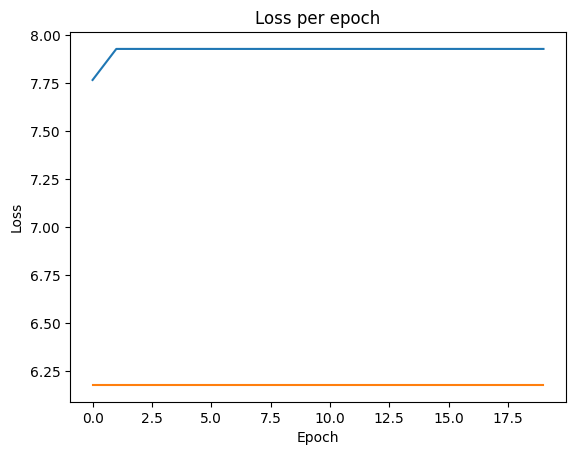

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

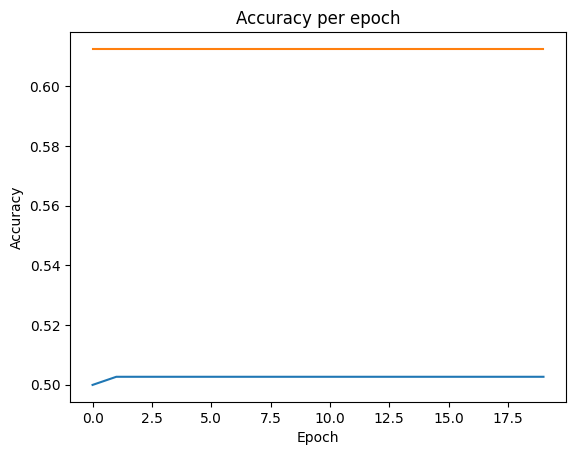

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

In [18]:
import keras
from keras.models import load_model

# Load the model from the file
model1 = load_model("model.keras")

# Evaluate the model on the test data
results = model1.evaluate(test_images, test_labels)

# Print the results
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.8386 - loss: 2.5725
Test Loss: 7.161477088928223
Test Accuracy: 0.5507900714874268


In [19]:
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
densenet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=densenet121_model.input, outputs=densenet121_model.get_layer('conv5_block6_concat').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False
    
# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_4 (Cast)             │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ cast_4[0][0]           │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat  

 Total params: 6,263,233 (23.89 MB)

 Trainable params: 722,945 (2.76 MB)

 Non-trainable params: 5,540,288 (21.13 MB)

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=20, batch_size=250,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.6299 - loss: 0.6445
Epoch 1: val_accuracy improved from -inf to 0.79974, saving model to model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6316 - loss: 0.6433 - val_accuracy: 0.7997 - val_loss: 0.4881 - learning_rate: 0.0010
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.7611 - loss: 0.4982
Epoch 2: val_accuracy improved from 0.79974 to 0.82853, saving model to model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - accuracy: 0.7616 - loss: 0.4975 - val_accuracy: 0.8285 - val_loss: 0.3975 - learning_rate: 0.0010
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8155 - loss: 0.4067
Epoch 3: val_accuracy improved from 0.82853 to 0.84162, saving model to model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 325ms/step - accuracy: 0.8157 - loss: 0.4065 - val_accuracy: 0.8416 - val_loss: 0.3555 - learning_rate: 0.0010
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8474

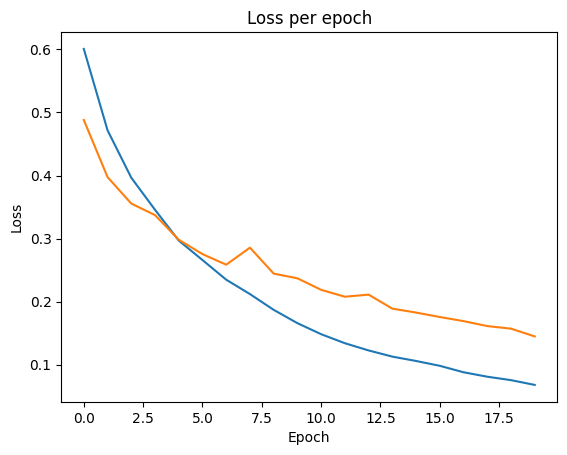

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

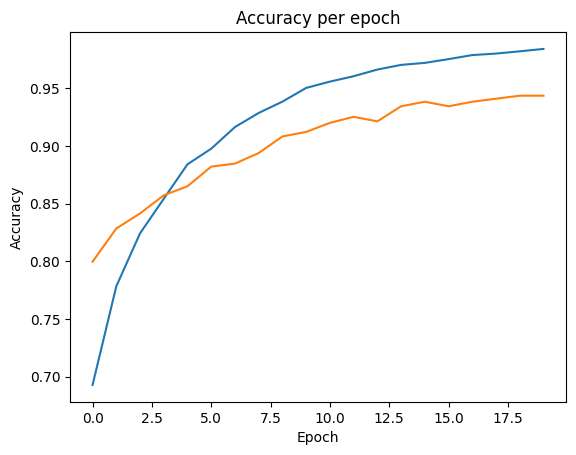

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

In [23]:
import keras
from keras.models import load_model

# Load the model from the file
model1 = load_model("model.keras")

# Evaluate the model on the test data
results = model1.evaluate(test_images, test_labels)

# Print the results
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 731ms/step - accuracy: 0.9140 - loss: 0.2397
Test Loss: 0.1778278350830078
Test Accuracy: 0.943566620349884


In [24]:
from keras.applications import Xception
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=xception_model.input, outputs=xception_model.get_layer('block14_sepconv2_act').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_6 (Cast)             │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ cast_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool          

 Total params: 22,960,681 (87.59 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=20, batch_size=250,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.7170 - loss: 0.5622
Epoch 1: val_accuracy improved from -inf to 0.89921, saving model to model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7191 - loss: 0.5588 - val_accuracy: 0.8992 - val_loss: 0.2659 - learning_rate: 0.0010
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9281 - loss: 0.2026
Epoch 2: val_accuracy improved from 0.89921 to 0.92670, saving model to model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 476ms/step - accuracy: 0.9286 - loss: 0.2018 - val_accuracy: 0.9267 - val_loss: 0.2075 - learning_rate: 0.0010
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9777 - loss: 0.0956
Epoch 3: val_accuracy improved from 0.92670 to 0.95681, saving model to model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 476ms/step - accuracy: 0.9778 - loss: 0.0954 - val_accuracy: 0.9568 - val_loss: 0.1313 - learning_rate: 0.0010
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9862

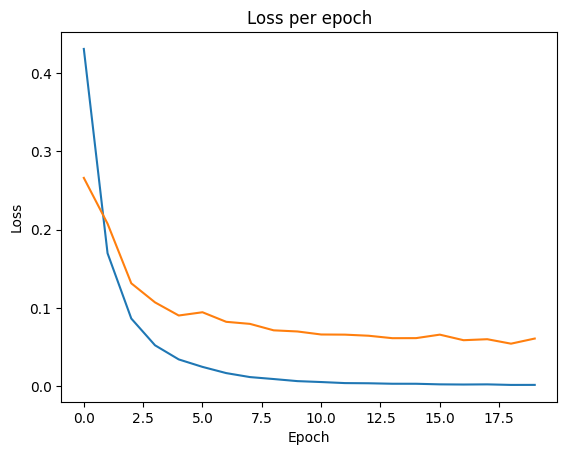

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

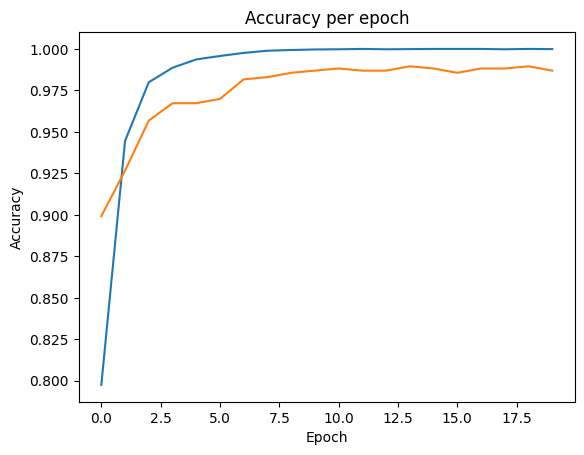

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

In [28]:
import keras
from keras.models import load_model

# Load the model from the file
model1 = load_model("model.keras")

# Evaluate the model on the test data
results = model1.evaluate(test_images, test_labels)

# Print the results
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 397ms/step - accuracy: 1.0000 - loss: 0.0049
Test Loss: 0.0036248203832656145
Test Accuracy: 1.0


In [29]:
from keras.applications import InceptionV3
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=inception_model.input, outputs=inception_model.get_layer('mixed10').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# binding model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_8 (Cast)             │ (None, 224, 224, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 111, 111, 32)   │            864 │ cast_8[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 111, 111, 32)   │             96 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 109, 109, 32)   │             96 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 109, 109, 64)   │            192 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 54, 54, 80)     │            240 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8

 Total params: 23,901,985 (91.18 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=20, batch_size=250,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.4925 - loss: 7.3478
Epoch 1: val_accuracy improved from -inf to 0.38743, saving model to model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.4926 - loss: 7.3627 - val_accuracy: 0.3874 - val_loss: 9.8734 - learning_rate: 0.0010
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.4972 - loss: 8.1035
Epoch 2: val_accuracy did not improve from 0.38743
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step - accuracy: 0.4972 - loss: 8.1034 - val_accuracy: 0.3874 - val_loss: 9.8734 - learning_rate: 0.0010
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.5042 - loss: 7.9921
Epoch 3: val_accuracy did not improve from 0.38743
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 276ms/step - accuracy: 0.5040 - loss: 7.9950 - val_accuracy: 0.3874 - val_loss: 9.8734 - learning_rate: 0.0010
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.4981 - loss: 8.0902
Epoch 4: val_accuracy did not improve from 0.38743

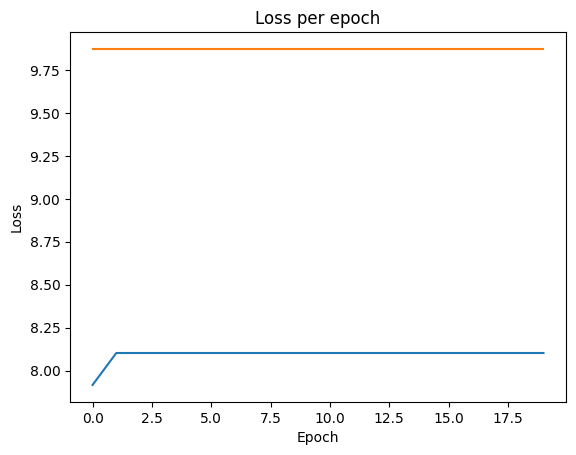

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

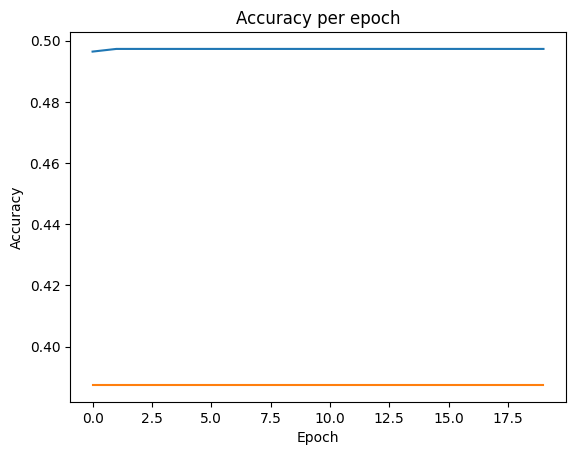

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

In [33]:
import keras
from keras.models import load_model

# Load the model from the file
model1 = load_model("model.keras")

# Evaluate the model on the test data
results = model1.evaluate(test_images, test_labels)

# Print the results
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 574ms/step - accuracy: 0.1614 - loss: 13.5172
Test Loss: 8.877686500549316
Test Accuracy: 0.44920992851257324


In [34]:
from keras.applications import MobileNet
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Loading MobileNet model
mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=mobilenet_model.input, outputs=mobilenet_model.get_layer('conv_pw_13_relu').output)

# Freezing convolutional layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Adding dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Binding model
model = Model(inputs=feature_extractor.input, outputs=output)

# Setting up callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)

model.summary() # model summary

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_10 (Cast)                       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,279,489 (16.32 MB)

 Trainable params: 1,050,625 (4.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [35]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=20, batch_size=250,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5968 - loss: 1.2782
Epoch 1: val_accuracy improved from -inf to 0.87042, saving model to model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 442ms/step - accuracy: 0.5996 - loss: 1.2669 - val_accuracy: 0.8704 - val_loss: 0.3094 - learning_rate: 0.0010
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8866 - loss: 0.2731
Epoch 2: val_accuracy improved from 0.87042 to 0.92801, saving model to model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.8872 - loss: 0.2719 - val_accuracy: 0.9280 - val_loss: 0.2061 - learning_rate: 0.0010
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9632 - loss: 0.1326
Epoch 3: val_accuracy improved from 0.92801 to 0.95288, saving model to model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9633 - loss: 0.1321 - val_accuracy: 0.9529 - val_loss: 0.1411 - learning_rate: 0.0010
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.989

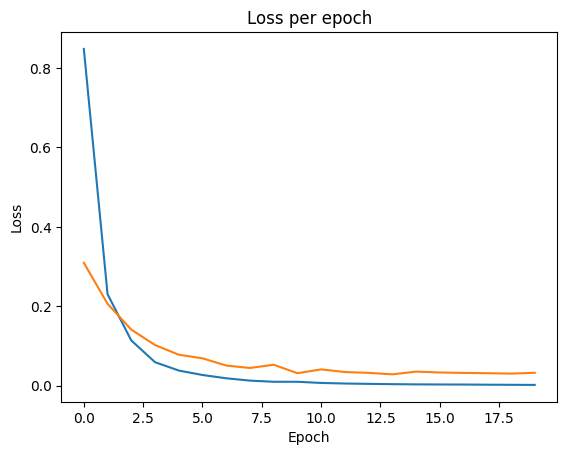

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

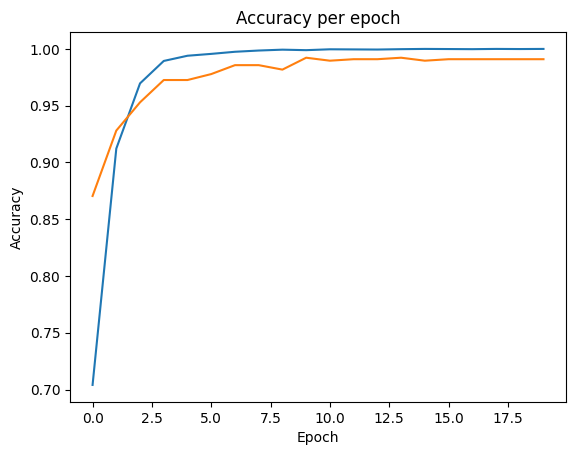

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

In [38]:
import keras
from keras.models import load_model

# Load the model from the file
model1 = load_model("model.keras")

# Evaluate the model on the test data
results = model1.evaluate(test_images, test_labels)

# Print the results
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 1.0000 - loss: 0.0216
Test Loss: 0.01640966534614563
Test Accuracy: 1.0


In [39]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, InputLayer
from keras.regularizers import l1_l2

model = Sequential()

model.add(InputLayer(shape=(224, 224, 3))) # input layer

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

# convolutional block
model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(GlobalAveragePooling2D()) # pooling down

model.add(Dense(1024, activation='relu')) # dense layer

model.add(Dense(1, activation='sigmoid')) # output layer

model.summary() # model summary

# model checkpoint callback
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_98 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_98               │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_99 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_99               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_100 (Conv2D)                  │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_100              │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_101 (Conv2D)                  │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_101              │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 283,905 (1.08 MB)

 Trainable params: 283,265 (1.08 MB)

 Non-trainable params: 640 (2.50 KB)

In [40]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # compiling and fitting model
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=30, batch_size=100,callbacks=[model_checkpoint])

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7364 - loss: 0.5152
Epoch 1: val_accuracy improved from -inf to 0.52880, saving model to model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 335ms/step - accuracy: 0.7372 - loss: 0.5142 - val_accuracy: 0.5288 - val_loss: 0.6908
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9084 - loss: 0.2421
Epoch 2: val_accuracy improved from 0.52880 to 0.61387, saving model to model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9086 - loss: 0.2418 - val_accuracy: 0.6139 - val_loss: 1.4148
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9604 - loss: 0.1190
Epoch 3: val_accuracy improved from 0.61387 to 0.63482, saving model to model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.9604 - loss: 0.1189 - val_accuracy: 0.6348 - val_loss: 1.8092
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9705 - loss: 0.0868
Epoch 4: val_accuracy did not improve from 0.63482
92

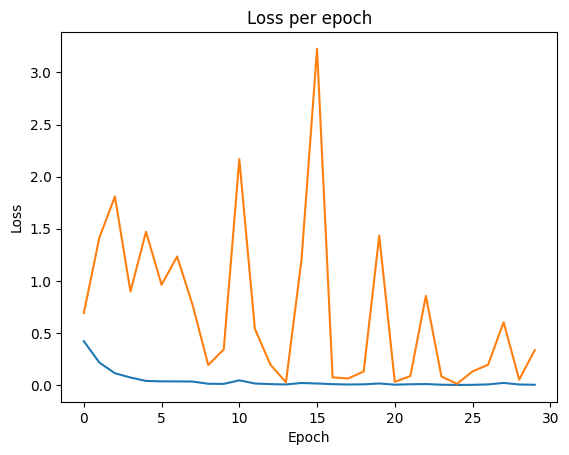

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

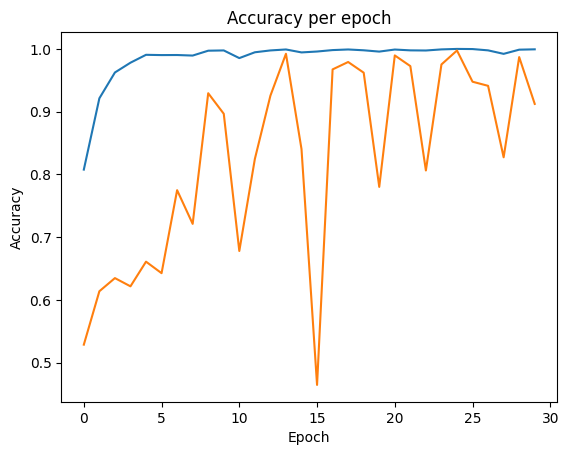

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

In [43]:
import keras
from keras.models import load_model

# Load the model from the file
model1 = load_model("model.keras")

# Evaluate the model on the test data
results = model1.evaluate(test_images, test_labels)

# Print the results
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 0.0040
Test Loss: 0.0039975144900381565
Test Accuracy: 1.0
